In [1]:
from network_evaluation_tools import gene_conversion_tools as gct
from network_evaluation_tools import data_import_tools as dit
import pandas as pd
import itertools
import matplotlib.pyplot as plt

In [2]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2
## Load BioPlex Raw Data
#### Source: https://bioplex.hms.harvard.edu/data/BioPlex_293T_Network_10K_Dec_2019.tsv; https://bioplex.hms.harvard.edu/data/BioPlex_HCT116_Network_5.5K_Dec_2019.tsv
Downloaded: November 16, 2021   
Last Updated: December, 2019  
This latest update of BioPlex is associated with the recent paper: Huttlin et al. 2021 https://doi.org/10.1101/2020.01.19.905109.   

**Note:** In addition to additional data from 293T cells (v3.0), there is also published data from HCT116 cells (v1.0). These two datasets are merged.  
**Note:** We could use the 'pInt' column as a scoring metric to filter the network further, but we have chosen not to for consistency with the original PCNet publication. 

In [3]:
BioPlex_293T_Raw = pd.read_csv(wd+'Network_Data_Raw/BioPlex_293T_Network_10K_Dec_2019.tsv',sep='\t')
BioPlex_HCT116_Raw = pd.read_csv(wd+'Network_Data_Raw/BioPlex_HCT116_Network_5.5K_Dec_2019.tsv',sep='\t')
print('Raw edge count in BioPlex (293T):', len(BioPlex_293T_Raw))
print('Raw edge count in BioPlex (HCT116):', len(BioPlex_HCT116_Raw))

Raw edge count in BioPlex (293T): 118162
Raw edge count in BioPlex (HCT116): 70966


In [4]:
## Combine the two datasets. Where edges exist in both cell lines, keep the row with the lowest pInt
input_raw_v2 = pd.concat([BioPlex_293T_Raw, BioPlex_HCT116_Raw])
print('Concatenated list of edges:', input_raw_v2.shape)
input_raw_v2.sort_values(by="pInt", inplace=True)
input_raw_v2 = input_raw_v2.drop_duplicates(subset=["GeneA", "GeneB", "UniprotA", "UniprotB", "SymbolA", "SymbolB"], keep='first')
print('After duplicate edges removed:', input_raw_v2.shape)

Concatenated list of edges: (189128, 9)
After duplicate edges removed: (173972, 9)


In [5]:
# Convert table of interactions to edgelist (no scores given)
# Also no gene symbol conversion necessary because network is given in symbol format already
edgelist_v2 = input_raw_v2[['SymbolA', 'SymbolB']].values.tolist()
print('Edges in BIND:', len(edgelist_v2))

Edges in BIND: 173972


In [6]:
# Sort each edge representation for filtering
edgelist_sorted_v2 = [sorted(edge) for edge in edgelist_v2]
edgelist_sorted_v2 = pd.DataFrame(edgelist_sorted_v2, columns=["symbol_n1", "symbol_n2"])

## Query symbols

In [7]:
genes_v2 = (list(set(edgelist_sorted_v2["symbol_n1"]).union(set(edgelist_sorted_v2["symbol_n2"]))))
query_string_v2, valid_genes_v2, invalid_genes_v2 = gct.query_constructor(genes_v2)

14550 Valid Query Genes
1 Invalid Query Genes


In [8]:
mapped_v2, unmapped_v2 = gct.query_against_dataset("~/Data/Network_Analysis/Reference_Data/HGNC_download_2022.txt",
                              valid_genes_v2, return_as_dict=True)
match_table_trim_v2, query_to_symbol_v2, query_to_entrez_v2 = gct.construct_query_map_table(mapped_v2, valid_genes_v2)

Number of genes with multiple matches: 10
Number of unmatched genes: 50
Number of fully matched genes: 14423
Number of partially matched genes: 127


In [9]:
edgelist_updated_v2 = gct.convert_edgelist(edgelist_sorted_v2, query_to_symbol_v2)
# Filter edgelist for duplicate nodes and for self-edges
edgelist_filt_v2 = gct.filter_converted_edgelist(edgelist_updated_v2)

173972 input edges
3 self-edges removed
796 edges with un-mapped genes removed
6598 duplicate edges removed
Edge list filtered: 0.08 seconds
166575 Edges remaining


In [10]:
# Write network to file
gct.write_edgelist(edgelist_filt_v2, wd+'Processed_Data/Network_SIFs_Symbol/BioPlex_Symbol_2019.sif', binary=True)

Edge list saved: 0.18 seconds


# Version 1
## Load BioPlex Raw Data
**Source: http://bioplex.hms.harvard.edu/data/BioPlex_interactionList_v4a.tsv**  

Downloaded: June 20, 2017  
Last Updated: December 01, 2016     
This latest update of BioPlex (2.0 v4) is associated with the recent paper: Huttlin et al. (2017) Nature doi: 10.1038/nature22366  
Note: We could use the 'p(Interaction)' column as a scoring metric to filter the network further, however, a top 10% filtering of this network would yield a network with <6000 interactions, so we did not feel like it was necessary to filter the network further for analysis.

In [11]:
input_raw = pd.read_csv(wd+'Network_Data_Raw/BioPlex_interactionList_v4a.tsv',sep='\t')
print('Raw edge count in BioPlex:', len(input_raw))

Raw edge count in BioPlex: 56553


In [12]:
input_raw.head()

,GeneA,GeneB,UniprotA,UniprotB,SymbolA,SymbolB,p(Wrong),p(No Interaction),p(Interaction)
0,100,728378,P00813,A5A3E0,ADA,POTEF,2.380858e-09,0.000332,0.999668
1,100,345651,P00813,Q562R1,ADA,ACTBL2,9.786437e-18,0.211914,0.788086
2,222389,708,Q8N7W2,Q07021,BEND7,C1QBP,2.962215e-17,0.005645,0.994355
3,222389,4038,Q8N7W2,O75096,BEND7,LRP4,3.302994e-10,0.000280,0.999720
4,645121,3312,Q6ZMN8,P11142,CCNI2,HSPA8,2.060285e-16,0.036235,0.963765


In [13]:
# Convert table of interactions to edgelist (no scores given)
# Also no gene symbol conversion necessary because network is given in symbol format already
edgelist = input_raw[['SymbolA', 'SymbolB']].values.tolist()
print('Edges in Bioplex:', len(edgelist))

Edges in Bioplex: 56553


In [14]:
# Sort each edge representation for filtering
edgelist_sorted = [sorted(edge) for edge in edgelist]
edgelist_sorted = pd.DataFrame(edgelist_sorted, columns=["symbol_n1", "symbol_n2"])

## Query symbols

In [15]:
genes = (list(set(edgelist_sorted["symbol_n1"]).union(set(edgelist_sorted["symbol_n2"]))))
query_string, valid_genes, invalid_genes = gct.query_constructor(genes)

10961 Valid Query Genes
0 Invalid Query Genes


In [16]:
mapped, unmapped = gct.query_against_dataset("~/Data/Network_Analysis/Reference_Data/HGNC_download_2022.txt",
                              valid_genes, return_as_dict=True)
match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(mapped, valid_genes)

Number of genes with multiple matches: 8
Number of unmatched genes: 27
Number of fully matched genes: 10876
Number of partially matched genes: 85


In [17]:
edgelist_updated = gct.convert_edgelist(edgelist_sorted, query_to_symbol)
# Filter edgelist for duplicate nodes and for self-edges
edgelist_filt = gct.filter_converted_edgelist(edgelist_updated)

56553 input edges
3 self-edges removed
213 edges with un-mapped genes removed
11 duplicate edges removed
Edge list filtered: 0.03 seconds
56326 Edges remaining


In [18]:
# Write network to file
gct.write_edgelist(edgelist_filt, wd+'Processed_Data/Network_SIFs_Symbol/BioPlex_Symbol_v4a_2016.sif', binary=True)

Edge list saved: 0.07 seconds


# Changes

No human filtering done


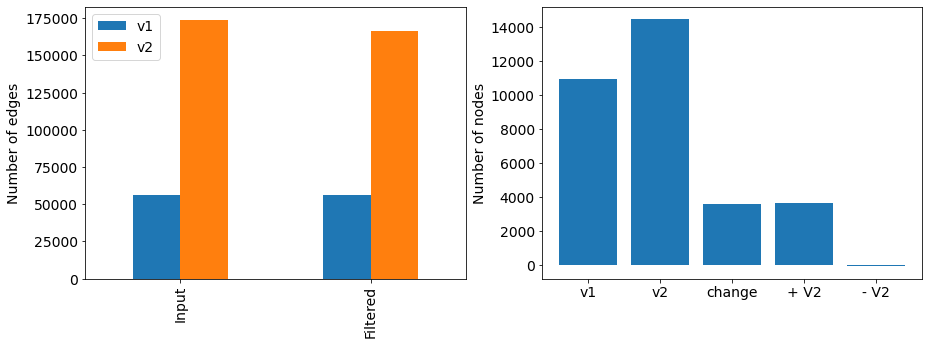

In [19]:
dit.plot_changes_to_dataset(input_raw, input_raw_v2, edgelist_filt, edgelist_filt_v2)

In [21]:
len(set(edgelist_filt["symbol_n1"]).union(set(edgelist_filt["symbol_n2"])))

10920

In [22]:
len(set(edgelist_filt_v2["symbol_n1"]).union(set(edgelist_filt_v2["symbol_n2"])))

14471